<a href="https://colab.research.google.com/github/rubyclaguna/AB-Demo/blob/master/BW_NN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load Leafly dataset

import pandas as pd 
import numpy as np 
import spacy 


df1 = pd.read_csv('./cannabis.csv')
#df2 = pd.read_csv('./medcabinet_data.csv')

print(df1.shape)
df1.head()

(2351, 6)


,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [123]:
#df2.head()

,Unnamed: 0,Strain,Type,Rating,Description,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,None,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,nan,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth
0,0,100-Og,hybrid,4.0,$100 OG is a 50/50 hybrid strain that packs a ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1,98-White-Widow,hybrid,4.7,The ‘98 Aloha White Widow is an especially pot...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
2,2,1024,sativa,4.4,1024 is a sativa-dominant hybrid bred in Spain...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0
3,3,13-Dawgs,hybrid,4.2,13 Dawgs is a hybrid of G13 and Chemdawg genet...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0
4,4,24K-Gold,hybrid,4.6,"Also known as Kosher Tangie, 24k Gold is a 60%...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0


In [124]:
#df2 = df2.drop(['Unnamed: 0'], axis=1)

In [126]:
#df2.shape

(2351, 70)

In [127]:
# Check for any missing values

#df2.isnull().sum()

Strain          0
Type            0
Rating          0
Description    33
Earthy          0
               ..
Giggly          0
Focused         0
Sleepy          0
Dry             0
Mouth           0
Length: 70, dtype: int64

In [2]:
df1.isnull().sum()

Strain          0
Type            0
Rating          0
Effects         0
Flavor         46
Description    33
dtype: int64

In [129]:
# Fill missing values

#df2["Description"] = df2["Description"].fillna("None")

In [3]:
df1["Flavor"] = df1["Flavor"].fillna("None")
df1["Description"] = df1["Description"].fillna("None")

In [4]:
df1['Type'].unique()

array(['hybrid', 'sativa', 'indica'], dtype=object)

In [5]:
df1['Type'].value_counts(ascending=False)

hybrid    1212
indica     699
sativa     440
Name: Type, dtype: int64

In [6]:
df1.columns.to_list()

['Strain', 'Type', 'Rating', 'Effects', 'Flavor', 'Description']

In [7]:
df1.describe()

,Rating
count,2351.000000
mean,4.310634
std,0.836394
min,0.000000
25%,4.200000
50%,4.400000
75%,4.700000
max,5.000000


In [8]:
df1['Rating'].unique()

array([4. , 4.7, 4.4, 4.2, 4.6, 0. , 4.5, 4.3, 5. , 3.8, 4.1, 4.8, 3.4,
       3.7, 3.9, 3. , 4.9, 3.6, 2.8, 3.3, 3.5, 3.2, 2. , 1. , 3.1, 2.5])

Model MVP: Nearest Neighbors

In [9]:
# Start NLP 
import pandas as pd
from collections import Counter

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
from nltk.stem import PorterStemmer
import spacy
from spacy.tokenizer import Tokenizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=dbf318b06393f1dd7136d5e78b5643e3dcf9bdef362881fec5df8580a36350c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-m5nm72ke/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [10]:
# Initialize spacy model & tokenizer

nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

In [11]:
# Tokenize function

def tokenize(text):
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', ',', text)
    tokens = tokens.lower().replace(',', ' ')
    tokens = tokens.split()
    
    return tokens

In [12]:
# Tokenize Effects

df1['Effects_tokens'] = df1['Effects'].apply(tokenize)
df1['Effects_tokens'].head()

0    [creative, energetic, tingly, euphoric, relaxed]
1      [relaxed, aroused, creative, happy, energetic]
2     [uplifted, happy, relaxed, energetic, creative]
3       [tingly, creative, hungry, relaxed, uplifted]
4     [happy, relaxed, euphoric, uplifted, talkative]
Name: Effects_tokens, dtype: object

In [13]:
# Tokenize Flavors

df1['Flavor_tokens'] = df1['Flavor'].apply(tokenize)
df1['Flavor_tokens'].head()

0          [earthy, sweet, citrus]
1        [flowery, violet, diesel]
2     [spicy, herbal, sage, woody]
3    [apricot, citrus, grapefruit]
4         [citrus, earthy, orange]
Name: Flavor_tokens, dtype: object

In [15]:
# Counter Function - takes a corpus of document and returns dataframe of word counts

from collections import Counter
 
word_counts = Counter()

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(list(temp), columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc

In [16]:
wc_effects = count(df1['Effects_tokens'])

wc_effects.sort_values(by='rank')

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
5,happy,1871,1871,1.0,0.166518,0.166518,0.795832
1,relaxed,1726,1726,2.0,0.153613,0.320132,0.734156
3,euphoric,1635,1635,3.0,0.145514,0.465646,0.695449
7,uplifted,1507,1507,4.0,0.134122,0.599769,0.641004
4,creative,747,747,5.0,0.066483,0.666251,0.317737
13,sleepy,738,738,6.0,0.065682,0.731933,0.313909
0,energetic,646,646,7.0,0.057494,0.789427,0.274777
12,focused,595,595,8.0,0.052955,0.842382,0.253084
8,hungry,479,479,9.0,0.042631,0.885012,0.203743
9,talkative,360,360,10.0,0.032040,0.917052,0.153126


In [17]:
wc_effects.shape

(16, 7)

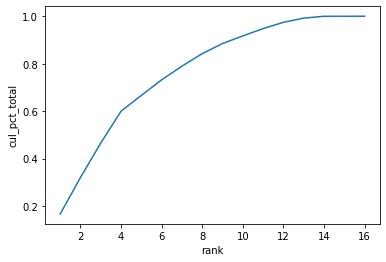

In [18]:
#Cumulative Distribution Plot

sns.lineplot(x='rank', y='cul_pct_total', data=wc_effects);

In [19]:
wc_flavor = count(df1['Flavor_tokens'])

wc_flavor.sort_values(by='rank')

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,earthy,1105,1105,1.0,0.160191,0.160191,0.470013
0,sweet,1053,1053,2.0,0.152653,0.312844,0.447895
2,citrus,527,527,3.0,0.076399,0.389243,0.224160
14,pungent,451,451,4.0,0.065381,0.454625,0.191833
18,berry,355,355,5.0,0.051464,0.506089,0.151000
16,pine,300,300,6.0,0.043491,0.549580,0.127605
3,flowery,267,267,7.0,0.038707,0.588286,0.113569
8,woody,255,255,8.0,0.036967,0.625254,0.108464
5,diesel,240,240,9.0,0.034793,0.660046,0.102084
7,spicy,226,226,10.0,0.032763,0.692810,0.096129


In [20]:
wc_flavor.shape

(51, 7)

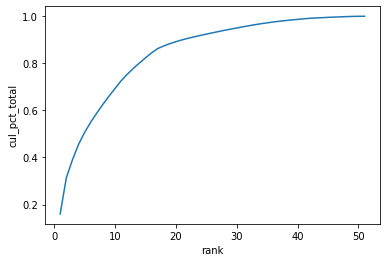

In [21]:
#Cumulative Distribution Plot

sns.lineplot(x='rank', y='cul_pct_total', data=wc_flavor);

In [22]:
# Unique effects

wc_effects = wc_effects.sort_values(by='rank')
wc_effects['word'].to_list()

['happy',
 'relaxed',
 'euphoric',
 'uplifted',
 'creative',
 'sleepy',
 'energetic',
 'focused',
 'hungry',
 'talkative',
 'tingly',
 'giggly',
 'aroused',
 'none',
 'dry',
 'mouth']

In [23]:
# Unique flavors 

wc_flavor = wc_flavor.sort_values(by='rank')
wc_flavor['word'].to_list()

['earthy',
 'sweet',
 'citrus',
 'pungent',
 'berry',
 'pine',
 'flowery',
 'woody',
 'diesel',
 'spicy',
 'herbal',
 'lemon',
 'skunk',
 'none',
 'tropical',
 'blueberry',
 'grape',
 'orange',
 'cheese',
 'pepper',
 'lime',
 'strawberry',
 'pineapple',
 'minty',
 'sage',
 'grapefruit',
 'chemical',
 'lavender',
 'vanilla',
 'tree',
 'fruit',
 'mango',
 'honey',
 'ammonia',
 'nutty',
 'coffee',
 'menthol',
 'butter',
 'mint',
 'tea',
 'apple',
 'rose',
 'apricot',
 'blue',
 'tobacco',
 'tar',
 'violet',
 'chestnut',
 'peach',
 'pear',
 'plum']

In [24]:
# Clean Description 

df1['Description'] = df1['Description'].str.replace(u'\xa0', u' ')
df1['Description'].head()

0    $100 OG is a 50/50 hybrid strain that packs a ...
1    The ‘98 Aloha White Widow is an especially pot...
2    1024 is a sativa-dominant hybrid bred in Spain...
3    13 Dawgs is a hybrid of G13 and Chemdawg genet...
4    Also known as Kosher Tangie, 24k Gold is a 60%...
Name: Description, dtype: object

In [25]:
# Inspect a few reviews to determine stopwords

df1['Description'].iloc[1]

'The ‘98 Aloha White Widow is an especially potent cut of White Widow that has grown in renown alongside Hawaiian legends like Maui Wowie and Kona Gold. This White Widow phenotype reeks of diesel and skunk and has a rich earthy taste with intermittent notes of hash. Its buds are coated in trichomes, giving its dark foliage a lustrous glint to go along with its room-filling odor. This one-hitter-quitter uplifts the mind with mind-bending euphoria that materializes in the body as airy relaxation. ‘98 Aloha White Widow is available from Pua Mana 1st Hawaiian Pakalōlō Seed Bank.  '

In [26]:
df1['Description'].iloc[2]

'1024 is a sativa-dominant hybrid bred in Spain by Medical Seeds Co. The breeders claim to guard the secret genetics due to security reasons, but regardless of its genetic heritage, 1024 is a THC powerhouse with a sweet and spicy bouquet. Subtle fruit flavors mix with an herbal musk to produce uplifting sativa effects. One specific phenotype is noted for having a pungent odor that fills a room, similar to burning incense.'

In [27]:
df1['Description'].iloc[3]

'13 Dawgs is a hybrid of G13 and Chemdawg genetics bred by Canadian LP Delta 9 BioTech. The two potent strains mix to create a balance between indica and sativa effects. 13 Dawgs has a sweet earthy musk that brings a blend of woody citrus flavors. The effects of 13 Dawgs induce a happy, relaxed body buzz with a creative and focused mind that counters depression and stimulates the appetite.'

In [28]:
df1['Description'].iloc[4]

'Also known as Kosher Tangie, 24k Gold is a 60% indica-dominant hybrid that combines the legendary LA strain Kosher Kush with champion sativa Tangie to create something quite unique. Growing tall in its vegetative cycle and very stretchy in flower, this one will need an experienced hand when grown indoors. Most phenotypes will exhibit a sweet orange aroma from the Tangie along with the dark coloration of the Kosher Kush, and will offer a strong citrus flavor when smoked or vaped. THC levels range from 18% to 24%; definitely not for novice users! '

In [29]:
df1['Description'].iloc[5]

'3 Bears OG by Mephisto Genetics is an autoflowering cross of Bear OG, Karma’s OG Cut, and Triangle Kush. This indica-dominant strain generates pungent, flavorful buds in a smaller, more manageable plant size. Mephisto Genetics describes 3 Bears OG as a cornerstone to their artisanal collection, blending the best attributes of the fabled OG Kush with a compact, controllable growth structure. The 3 Bears OG has an approximate 70-day growth cycle and offers effects that stimulate the appetite while leading the body toward sleep.'

In [30]:
# Tokenizer Pipe
from spacy.tokenizer import Tokenizer

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

tokens = []
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'weed','strain','thc','grow','growing','flower','grown','smoke','smoked',
                                            'vape','vaped','kush','  ','generate','generates','bud','buds','plant','growth','body',
                                            'year','years',
                                            ])

for doc in tokenizer.pipe(df1['Description'], batch_size=500):
    doc_tokens = []   
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower()) 
    tokens.append(doc_tokens)

df1['Combined_Desc'] = tokens

In [31]:
df1['Combined_Desc'] = df1['Effects']+""+df1['Flavor']+""+df1['Description']

In [32]:
df1.head()

,Strain,Type,Rating,Effects,Flavor,Description,Effects_tokens,Flavor_tokens,Combined_Desc
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,"[creative, energetic, tingly, euphoric, relaxed]","[earthy, sweet, citrus]","Creative,Energetic,Tingly,Euphoric,RelaxedEart..."
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,"[relaxed, aroused, creative, happy, energetic]","[flowery, violet, diesel]","Relaxed,Aroused,Creative,Happy,EnergeticFlower..."
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,"[uplifted, happy, relaxed, energetic, creative]","[spicy, herbal, sage, woody]","Uplifted,Happy,Relaxed,Energetic,CreativeSpicy..."
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,"[tingly, creative, hungry, relaxed, uplifted]","[apricot, citrus, grapefruit]","Tingly,Creative,Hungry,Relaxed,UpliftedApricot..."
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...","[happy, relaxed, euphoric, uplifted, talkative]","[citrus, earthy, orange]","Happy,Relaxed,Euphoric,Uplifted,TalkativeCitru..."


In [33]:
# Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate Vectorizer
tfidf = TfidfVectorizer(stop_words='english', 
                        max_features=5000)

# Create a vocabulary and tf-idf score per description
dtm = tfidf.fit_transform(df1['Combined_Desc'])

# Get feature names to use as dataframe column headers
general_dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

general_dtm.head()

,09,10,100,11,12,13,14,15,16,17,18,19,1960s,1970s,1980s,1989,1990s,1991,1996,1997,1998,1999,1st,20,2000,2000s,2002,2003,2004,2005,2006,2007,2009,2010,2011,2012,2013,2014,2015,2016,...,wowie,wrapped,wrapping,wreathed,wreck,wrench,wtf,x18,xanadu,xiii,xj,xxx,y2k,year,years,yellow,yeti,yield,yielder,yielders,yielding,yields,yoda,york,yum,yummy,yunnan,zacatecas,zealand,zelly,zen,zest,zestful,zesty,zeta,zion,zkittlez,zombie,zone,zoning
0,0.0,0.0,0.410659,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.308341,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.136724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.neighbors import NearestNeighbors

# Fit on dtm
nn = NearestNeighbors(n_neighbors=5, algorithm='brute')
nn.fit(general_dtm)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [44]:
# Test input

ex_input = ['depression, hungry, earthy']
dense1 = tfidf.transform(ex_input)

_, results1 = nn.kneighbors(dense1.todense())
results1

array([[1321,  955,  362, 1093, 1368]])

In [45]:
# Inspect most relevant result

df1.Combined_Desc[1321]

'Happy,Uplifted,Hungry,Talkative,EnergeticSweet,Earthy,CitrusMad Dog is a hybrid strain that delivers euphoric relaxation and a subtle, uplifting jolt of cerebral energy. It has an earthy pine aroma with sweet, minty undertones.'

In [46]:
# Format Results better!!!!

In [47]:
# View top 5 relevant strains for 'depression'

strains = [df1['Strain'][r] for r in results1]
print('- - - - Strains - - - - ')
print(strains, sep='\n\n')
print(end="\n\n")

types = [df1['Type'][r] for r in results1]
print('- - -  Types - - - ')
print(types, sep='\n\n')
print(end="\n\n")

ratings = [df1['Rating'][r] for r in results1]
print('- - - Ratings - - -')
print(ratings, sep='\n\n')
print(end="\n\n")

similar_flavors = [df1['Flavor'][r] for r in results1]
print('- - - Flavors - - -')
print(similar_flavors, sep='\n\n')
print(end="\n\n")

similar_effects = [df1['Effects'][r] for r in results1]
print('- - -  Effects - - - ')
print(similar_effects, sep='\n\n')
print(end="\n\n")


similar_topics = [df1['Description'][r] for r in results1]
print('- - -  Descriptions - - - ')
print(similar_topics, sep='\n\n')

- - - - Strains - - - - 
[1321         Mad-Dawg
955     Green-Monster
362        Boggle-Gum
1093             Jt15
1368       Maui-Berry
Name: Strain, dtype: object]


- - -  Types - - - 
[1321    hybrid
955     hybrid
362     hybrid
1093    indica
1368    hybrid
Name: Type, dtype: object]


- - - Ratings - - -
[1321    4.5
955     3.7
362     4.0
1093    5.0
1368    4.0
Name: Rating, dtype: float64]


- - - Flavors - - -
[1321     Sweet,Earthy,Citrus
955      Earthy,Chemical,Tar
362       Sweet,Earthy,Grape
1093                    None
1368    Berry,Citrus,Pungent
Name: Flavor, dtype: object]


- - -  Effects - - - 
[1321    Happy,Uplifted,Hungry,Talkative,Energetic
955          Happy,Relaxed,Uplifted,Hungry,Giggly
362            Happy,Relaxed,Hungry,Sleepy,Giggly
1093         Relaxed,Sleepy,Happy,Hungry,Uplifted
1368     Happy,Creative,Uplifted,Hungry,Energetic
Name: Effects, dtype: object]


- - -  Descriptions - - - 
[1321    Mad Dog is a hybrid strain that delivers eupho...
955    

In [48]:
# Save Nearest Neighbors Model

import pickle

filename = "knn_model.pkl"
pickle.dump(nn, open(filename, "wb"))

In [49]:
# Save dtm 

filename2 = 'knn_dtm.pkl'
pickle.dump(dtm, open(filename2, 'wb'))

In [50]:
# Save tfidf

filename3 = 'knn_tfidf.pkl'
pickle.dump(tfidf, open(filename3, 'wb'))

In [53]:
# Load Model - Test to make sure it still functions. 

model = pickle.load(open("knn_model.pkl", "rb"))
query = ["Euphoric, Happy, Blueberry"]
trans = tfidf.transform(query)
model.kneighbors(trans.todense())[1]

array([[191, 301, 335, 340, 622]])

In [54]:
df1.Strain[191]

'Berry-Og'

In [55]:
df1.Rating[191]

4.3

In [56]:
df1.Effects[191]

'Happy,Relaxed,Uplifted,Euphoric,Sleepy'

In [57]:
df1.Flavor[191]

'Berry,Blueberry,Earthy'

In [58]:
df1.Description[191]

'Berry OG is an indica-dominant hybrid cross between OG Kush and Blueberry.'